In [1]:
import json
from tqdm.notebook import tqdm
from fastai.vision.all import *
torch.cuda.is_available()

default_device()

/home/logan/miniconda3/envs/organickdev/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libjpeg.so.8: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


device(type='cuda', index=0)

In [2]:
torch.cuda.is_available(), torch.version.cuda

(True, '11.2')

In [3]:
data_base = Path("../../School/Senior Design").resolve()
data_dir = data_base / "train_mini"
data_json = data_base / "train_mini.json"
data_dir, data_json, data_dir.exists(), data_json.exists()

(Path('/mnt/c/Users/Logan/Documents/School/Senior Design/train_mini'),
 Path('/mnt/c/Users/Logan/Documents/School/Senior Design/train_mini.json'),
 True,
 True)

In [4]:
# Probably only need Arthropoda from Animalia
folders = [*data_dir.glob("*")]
kingdoms = set()
animalia = set()

for folder in tqdm(folders):
    if not folder.is_dir():
        continue
    names = folder.name.split("_")
    kingdom, phylum = names[1:3]
    kingdoms.add(kingdom)
    if kingdom == "Animalia":
        animalia.add(phylum)
        
kingdoms, animalia

  0%|          | 0/10000 [00:00<?, ?it/s]

({'Animalia', 'Fungi', 'Plantae'},
 {'Annelida',
  'Arthropoda',
  'Chordata',
  'Cnidaria',
  'Echinodermata',
  'Mollusca'})

In [5]:
def get_annotes(fname):
    annot_dict = json.load(open(fname))
    id2images, id2cats = {}, collections.defaultdict(list)
    classes = {o['id']: o['name'] for o in annot_dict['categories']}
    for o in annot_dict['annotations']:
        id2cats[o['image_id']].append(classes[o['category_id']])
    id2images = {o['id']: data_base / o['file_name'] for o in annot_dict['images']}
    ids = list(id2images.keys())
    return [id2images[k] for k in ids], [id2cats[k] for k in ids]

imgs, labels = get_annotes(data_json)
labels = [label[0] for label in labels] # each label is a one-item list
len(imgs), len(labels), imgs[0], labels[0]

(500000,
 500000,
 Path('/mnt/c/Users/Logan/Documents/School/Senior Design/train_mini/02912_Animalia_Chordata_Actinopterygii_Siluriformes_Ictaluridae_Ameiurus_nebulosus/d615f184-8af4-4c60-b9f8-3081c1607644.jpg'),
 'Ameiurus nebulosus')

In [6]:
# Remove non-Arthropoda Animalia from dataset
new_imgs, new_labels = [], []
start_idx = len(str(imgs[0].parents[1])) + 1
for i, (img, label) in enumerate(zip(imgs, labels)):
    tag = str(img.parent)[start_idx:]
    if "Animalia" not in tag:
        new_imgs.append(img)
        new_labels.append(label)
    elif "Arthropoda" in tag:
        new_imgs.append(img)
        new_labels.append(label)
        
imgs, labels = new_imgs, new_labels
len(imgs), len(labels), imgs[0], labels[0]

(368200,
 368200,
 Path('/mnt/c/Users/Logan/Documents/School/Senior Design/train_mini/05804_Plantae_Tracheophyta_Liliopsida_Alismatales_Araceae_Peltandra_virginica/20c02c2d-a2c7-4f44-895c-ae3d5bb7c82c.jpg'),
 'Peltandra virginica')

In [7]:
dls = ImageDataLoaders.from_lists(data_base, imgs, labels, valid_pct=0.2,
                                   bs=64, item_tfms=Resize(460),
                                   batch_tfms=aug_transforms(size=224))

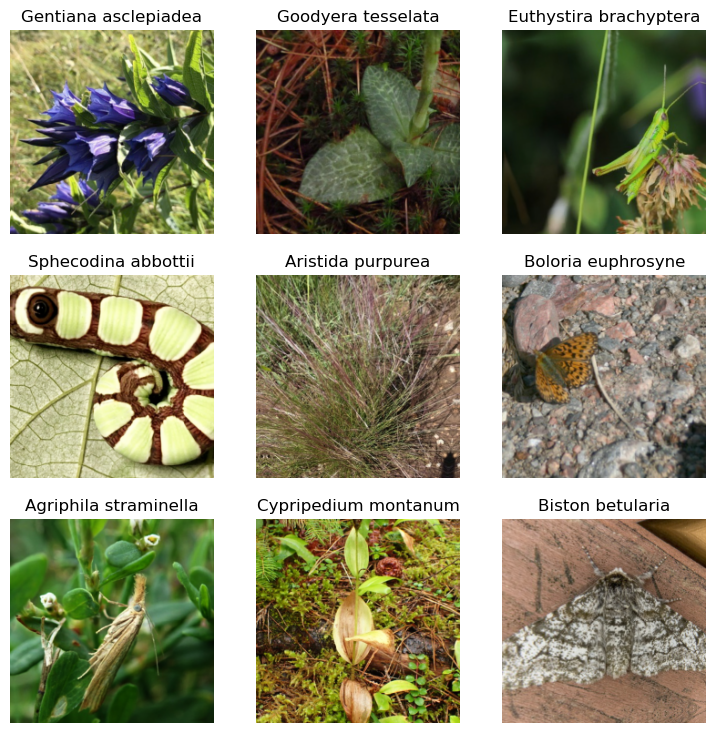

In [8]:
dls.show_batch()

In [11]:
learn = vision_learner(dls, resnet18, metrics=error_rate)

In [ ]:
learn.save("untrained")

SuggestedLRs(valley=0.0014454397605732083)

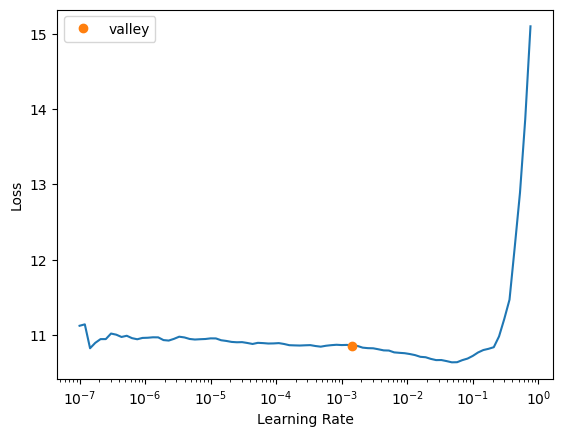

In [12]:
learn.lr_find()

In [ ]:
learn.fine_tune(10, 2e-2)

epoch,train_loss,valid_loss,error_rate,time


In [ ]:
learn.show_results()

In [ ]:
learn.save("10epochs")

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(10, 1e-3)

In [ ]:
learn.show_results()

In [ ]:
learn.save("25epochs")